### Library import

In [336]:
import pandas as pd
from pathlib import Path

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Plot libraries
import matplotlib as mpl
import matplotlib.pyplot as pp
from matplotlib import rc
import seaborn as sb

# Custom design for plots
%matplotlib inline
IPython_default = pp.rcParams.copy()
from matplotlib import rc, cycler
colors = cycler('color',
                ['#EE6666', # bright red
                 '#66EEEE', # bright blue
                 '#941111', # dark red
                 '#022869', # dark blue
                 '#9988DD', # purple
                 '#88BB44']) # green

mpl.rcParams['font.family'] = 'Arial'
params = {'figure.figsize': (14, 12),
         'axes.labelsize': 20,
         'axes.titlesize': 36,
         'xtick.labelsize':20,
         'ytick.labelsize':18,
         'legend.fontsize': 20,
         'legend.title_fontsize': 'xx-large',
         'axes.facecolor': '#FFFFFF',
         'axes.axisbelow': 'True',
         'axes.grid': 'False',
         'axes.prop_cycle': colors,
         'lines.linewidth': 2,
         'axes.xmargin' : 0.01}
mpl.rcParams.update(params)
pp.style.use('ggplot')

colors = ['#e24830', '#368bbd', '#988ed5', '#777777']
sb.set_palette(sb.color_palette(colors))

# Statistics libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

In [301]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

### Reading in data

In [4]:
PL1 = pd.read_excel(Path('am-ph-erdbeere-plate1-zsfg.xlsx'), header=1, skiprows=[0,1])
PL2 = pd.read_excel(Path('am-ph-erdbeere-plate2-zsfg.xlsx'), header=1, skiprows=[0,1])
PL3 = pd.read_excel(Path('am-ph-erdbeere-plate3-zsfg.xlsx'), header=1, skiprows=[0,1])
PL4 = pd.read_excel(Path('am-ph-erdbeere-plate4-zsfg.xlsx'), header=1, skiprows=[0,1])
PL5 = pd.read_excel(Path('am-ph-erdbeere-plate5-zsfg.xlsx'), header=1, skiprows=[0,1])

In [377]:
data_list = [PL1, PL2, PL3, PL4, PL5]
data = pd.concat(data_list)

In [378]:
list(data.columns)

['name',
 'weight (mg)',
 'SA',
 'JA',
 'ABA',
 'sum JA-Ile',
 'cis-OPDA',
 'Unnamed: 7',
 'OH-JA',
 'OH-JA-Ile',
 'COOH-JA-Ile',
 'Unnamed: 11',
 'IAA']

In [379]:
## Drop blank columns (RUN ON MAC)

data.drop(columns=['Unnamed: 7','Unnamed: 11'], inplace = True)

In [380]:
## Drop blank columns (RUN ON PC)

# data.drop(columns=['Unnamed: 7','Unnamed: 11', 'Unnamed: 13',
#  'Unnamed: 14',
#  'Unnamed: 15',
#  'Unnamed: 16',
#  'Unnamed: 17',
#  'Unnamed: 18',
#  'Unnamed: 19',
#  'Unnamed: 20'], inplace = True)

In [381]:
data.head()

,name,weight (mg),SA,JA,ABA,sum JA-Ile,cis-OPDA,OH-JA,OH-JA-Ile,COOH-JA-Ile,IAA
0,A1-N2_1A_1,22.3,9653.450648,212.737786,79.870262,19.875562,830.103195,3736.329346,25.802169,3.099187,4.336715
1,A2-N2_1A_2,20.1,8710.812758,227.944963,89.341982,12.880896,1694.883155,3974.417902,21.391344,5.988933,5.524452
2,A3-N2_1A_3,27.2,7292.682035,134.699668,62.899455,9.233586,3634.527611,2965.614321,14.267255,3.533697,4.020592
3,A4-N2_1B_1,17.5,20643.474009,83.715256,195.460266,16.516718,14058.934074,4733.290579,20.941612,5.813308,5.699357
4,A5-N2_1B_2,24.2,9403.850241,44.241515,86.075617,7.552604,5064.964818,2160.494242,8.085315,2.925506,4.487184


In [382]:
# Pull out sample ID and replicate from name column
data['Sample']= data['name'].str.extract(r'([I|N][0-4]{1,2}[_]\d{1,2}.)', expand = True)
data['Replicate'] = data['name'].str.extract(r'(.$)', expand = False)

# Drop name and weight column
data.drop(columns = ['name', 'weight (mg)'], inplace = True)

In [383]:
#Library of sample ID names
sampleID_treatment = {"A": "Arctic", 
                      "B": "Mid-latitude", 
                      "C": "D-Arctic", 
                      "D": "D-Mid-latitude"}

sampleID_zeitgeber = {"_2": "4", "_3": "8", 
                      "_4": "12", "_5": "16", "_6": "20", 
                      "_7": "24", "_8": "28", "_9": "32", 
                      "_10": "36", "_11": "40", "_12": "44", 
                      "_13": "48", "_1": "0"}

zt_to_24 = {"48": "24", "44": "20", "40": "16", "36": "12", 
            "32": "8", "28": "4", "24": "0","20": "20",
            "16": "16", "12": "12", "8": "8","4": "4",  "0": "0"}

sampleID_accession = {"I1": "IT1", "I4": "IT4", "N2": "NOR2", "N13": "NOR13"}

In [384]:
treatment_pattern = '(' + '|'.join(list(sampleID_treatment)) + ')'
zt_pattern = '(' + '|'.join(list(sampleID_zeitgeber)) + ')'
zt_to_24_pattern = '(' + '|'.join(list(zt_to_24)) + ')'
accession_pattern = '(' + '|'.join(list(sampleID_accession)) + ')'

In [385]:
data['Treatment'] = data.Sample.str.extract(treatment_pattern).squeeze().map(sampleID_treatment)
data['Zeitgeber'] = data.Sample.str.extract(zt_pattern).squeeze().map(sampleID_zeitgeber)
data['ZT_24'] = data.Zeitgeber.str.extract(zt_to_24_pattern).squeeze().map(zt_to_24)
data['Accession'] = data.Sample.str.extract(accession_pattern).squeeze().map(sampleID_accession)

In [386]:
# def define_new_column(df, col_dict, ID_col, new_col_name):
#     '''
#     Define a new column in dataframe based on keys in another column, using a dictionary
#     df = Pandas DataFrame
#     col_dictionary = dictionary for keys in columns and items to replace those keys with
#     sample_ID_col = column to call on (use quotations)
#     new_col_name = name of new column
#     '''

#     h = r'({})'.format('|'.join(col_dict.keys()))
#     extracted = df[ID_col].str.extract(h, expand=False).dropna()
    
#     df[new_col_name] = extracted.apply(lambda x: 
#                                     col_dict[x]).reindex(df.index).fillna(1)
#     return df

In [387]:
# define_new_column(data, sampleID_treatment, 'Sample_ID', 'Treatment')
# define_new_column(data, sampleID_zeitgeber, 'Sample_ID', 'Zeitgeber')
# define_new_column(data, sampleID_Accession, 'Sample_ID', 'Accession')
# define_new_column(data, zt_to_clock, 'Zeitgeber', 'ZT_24')

In [388]:
data.tail()

,SA,JA,ABA,sum JA-Ile,cis-OPDA,OH-JA,OH-JA-Ile,COOH-JA-Ile,IAA,Sample,Replicate,Treatment,Zeitgeber,ZT_24,Accession
51,28215.794937,247.935973,111.528446,29.386682,6474.836368,2522.441838,22.604565,13.892882,196.765686,I4_13C,2,D-Arctic,48,24,IT4
52,27695.136725,286.999026,126.383258,102.865374,3629.692493,2119.169379,33.788916,8.099207,102.487295,I4_13C,3,D-Arctic,48,24,IT4
53,22163.393155,226.479651,128.498773,25.278600,300.335484,2593.754383,33.086900,17.477412,176.642371,I4_13D,1,D-Mid-latitude,48,24,IT4
54,25610.393067,95.947778,208.257695,81.851553,724.687728,1464.287276,20.881524,10.720582,153.837788,I4_13D,2,D-Mid-latitude,48,24,IT4
55,22890.793706,138.332444,166.492554,24.937990,295.389711,2159.553482,20.296271,15.893771,167.952122,I4_13D,3,D-Mid-latitude,48,24,IT4


In [389]:
#Sort by accession and treatment
data.Zeitgeber = pd.to_numeric(data.Zeitgeber)
data.ZT_24 = pd.to_numeric(data.ZT_24)
data.sort_values(['Zeitgeber', 'ZT_24', 'Treatment', 'Sample', 'Replicate'], inplace = True)

data.set_index('Zeitgeber', inplace = True)
#Place ID columns in front of dataframe
data = data[data.columns[::-1]]
data

,Accession,ZT_24,Treatment,Replicate,Sample,IAA,COOH-JA-Ile,OH-JA-Ile,OH-JA,cis-OPDA,sum JA-Ile,ABA,JA,SA
Zeitgeber,,,,,,,,,,,,,,
0,IT1,0,Arctic,1,I1_1A,65.784102,24.031964,39.252254,3545.505413,3084.591490,20.036184,558.390835,182.121607,5130.962584
0,IT1,0,Arctic,2,I1_1A,56.268715,9.123972,24.336734,3792.681717,2020.483062,17.635381,616.730562,155.145338,7014.271891
0,IT1,0,Arctic,3,I1_1A,54.042476,8.383689,20.583411,3699.796939,9591.348682,11.300384,593.725490,108.701654,5626.867859
0,IT4,0,Arctic,1,I4_1A,42.957645,8.217553,26.034370,1244.484856,1421.001037,110.873082,53.963057,180.210045,21761.902449
0,IT4,0,Arctic,2,I4_1A,52.654623,6.514718,6.887354,983.302800,2973.421900,12.844402,36.217372,86.993917,23956.377470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,NOR13,24,Mid-latitude,2,N13_13B,40.831297,6.809346,9.062142,759.626758,5502.908043,7.087495,33.426171,46.535302,14503.713181
48,NOR13,24,Mid-latitude,3,N13_13B,73.322797,9.714808,57.096796,1146.380157,684.140133,37.027081,37.552355,621.896063,8499.803277
48,NOR2,24,Mid-latitude,1,N2_13B,6.509067,22.148570,62.298457,4796.949400,469.439244,23.247031,101.661834,863.467408,10798.772107


In [390]:
data.to_excel('Hormone_data.xlsx')

In [391]:
data.head()

,Accession,ZT_24,Treatment,Replicate,Sample,IAA,COOH-JA-Ile,OH-JA-Ile,OH-JA,cis-OPDA,sum JA-Ile,ABA,JA,SA
Zeitgeber,,,,,,,,,,,,,,
0,IT1,0,Arctic,1,I1_1A,65.784102,24.031964,39.252254,3545.505413,3084.591490,20.036184,558.390835,182.121607,5130.962584
0,IT1,0,Arctic,2,I1_1A,56.268715,9.123972,24.336734,3792.681717,2020.483062,17.635381,616.730562,155.145338,7014.271891
0,IT1,0,Arctic,3,I1_1A,54.042476,8.383689,20.583411,3699.796939,9591.348682,11.300384,593.725490,108.701654,5626.867859
0,IT4,0,Arctic,1,I4_1A,42.957645,8.217553,26.034370,1244.484856,1421.001037,110.873082,53.963057,180.210045,21761.902449
0,IT4,0,Arctic,2,I4_1A,52.654623,6.514718,6.887354,983.302800,2973.421900,12.844402,36.217372,86.993917,23956.377470


In [392]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ZT_24,440.0,11.945455,7.554614,0.000000,4.000000,12.000000,20.000000,24.000000
IAA,440.0,69.339953,46.958448,2.733853,43.095052,67.272551,91.779358,252.383104
COOH-JA-Ile,440.0,22.031280,17.962168,2.793299,10.430962,16.823416,25.932991,115.396434
OH-JA-Ile,440.0,35.927502,29.223416,5.263429,17.438658,26.717412,43.878281,220.958441
OH-JA,440.0,3461.705777,7175.222780,482.505821,1145.734276,1831.349178,3163.599747,59215.473817
cis-OPDA,440.0,4536.480252,6555.766843,100.307398,978.105560,2203.690975,5272.448706,54976.029946
sum JA-Ile,440.0,36.592457,41.731930,1.428449,11.305808,22.581599,43.119448,315.819560
ABA,440.0,266.799671,322.155242,28.769482,52.744540,100.695986,539.156146,1268.419519
JA,440.0,200.146027,215.923634,30.899017,93.580225,139.047684,208.697133,2084.757581
SA,440.0,14201.761470,8617.705122,3393.084882,8173.236151,12033.507623,18944.802383,91000.319697


Hormone data has extrememly high standard deviations. Do I need to do normalization?

In [393]:
data_melt = pd.melt(frame = data, 
                    id_vars = ['Sample', 'Accession', 'ZT_24', 'Treatment', 'Replicate'], 
                    var_name='Hormone', 
                    value_name = 'Value')
data_melt.head()

,Sample,Accession,ZT_24,Treatment,Replicate,Hormone,Value
0,I1_1A,IT1,0,Arctic,1,IAA,65.784102
1,I1_1A,IT1,0,Arctic,2,IAA,56.268715
2,I1_1A,IT1,0,Arctic,3,IAA,54.042476
3,I4_1A,IT4,0,Arctic,1,IAA,42.957645
4,I4_1A,IT4,0,Arctic,2,IAA,52.654623


Function to remove outliers

In [394]:
def locate_outlier_IQR(df):
    Q1=df['Value'].quantile(0.25)
    Q3=df['Value'].quantile(0.75)
    IQR=Q3-Q1
    low = Q1-1.5*IQR
    high = Q3+1.5*IQR
    new_df = df.loc[(df['Value'] > low) & (df['Value'] < high)]
    return (new_df)

In [395]:
custom_dict = {'Arctic' : 1, 'Mid-latitude' : 2, 'D-Arctic' : 3, 'D-Mid-latitude' : 4}


Function to pull out specific hormone data for individual analysis

In [397]:
def h_data(df, hormone):
    
    h_data = df.loc[df.Hormone == hormone]
    h_data = locate_outlier_IQR(h_data)
    h_data.loc[h_data['Treatment'].map(custom_dict).sort_values(ascending = True).index]
    return(h_data)

In [398]:
IAA = h_data(data_melt, 'IAA')
ABA = h_data(data_melt, 'ABA')
SA = h_data(data_melt, 'SA')
JA = h_data(data_melt, 'JA')
JA_Ile = h_data(data_melt, 'sum JA-Ile')
OH_JA = h_data(data_melt, 'OH-JA')

## Other hormones are degredation products, e.g. cis-OPDA. COOH-JA-Ile, OH-JA-Ile are rarely different.

In [399]:
IAA.tail()

,Sample,Accession,ZT_24,Treatment,Replicate,Hormone,Value
435,N13_13B,NOR13,24,Mid-latitude,2,IAA,40.831297
436,N13_13B,NOR13,24,Mid-latitude,3,IAA,73.322797
437,N2_13B,NOR2,24,Mid-latitude,1,IAA,6.509067
438,N2_13B,NOR2,24,Mid-latitude,2,IAA,6.702332
439,N2_13B,NOR2,24,Mid-latitude,3,IAA,5.422623


In [400]:
# def drop_dark(df):
#     new_df=df.drop(df[(df['Treatment'] == 'D-Arctic') | (df['Treatment'] == 'D-Mid-latitude')].index)              
#     return(new_df)

## Plotting functions

In [407]:
def show_boxplot(h):
    
    fig = pp.figure(figsize=(16,14))
    ax = sb.boxplot(x='Accession', y='Value', hue = 'Treatment', data = h)
    pp.title(get_df_name(h), fontsize = '36')
    ax.set_ylabel('ng/g dry weight', fontsize = 18)
    ax.set_xlabel('Accession', fontsize = '20')
    pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., title = 'Treatment', 
              title_fontsize = 'xx-large', fontsize=18)
    pp.savefig('Hormone_results_figures/Boxplot_' + get_df_name(h) + '.png', bbox_inches='tight', dpi=300)

In [401]:
def plot_hormone_zeitgeber(h):
    
    fig,ax = pp.subplots(2,2, figsize = (18,14), sharex = True, sharey = True)

    sb.lineplot(ax = ax[0,0], x='ZT_24', y='Value', hue='Accession', 
                err_style='bars', 
                data = h.loc[h.Treatment == 'Mid-latitude'], legend = False)
    ax[0,0].set_ylim(0, h['Value'].max())
    ax[0,0].set_ylabel('ng/g dry weight', fontsize = '18')
    ax[0,0].set_xticks(h.ZT_24.unique())

    # style='Treatment', 
    sb.lineplot(ax = ax[0,1], x='ZT_24', y='Value', hue='Accession', 
                err_style='bars', 
                data = h.loc[h.Treatment == 'D-Mid-latitude'], legend = False)
    ax[0,1].set_ylim(0, h['Value'].max())
    ax[0,1].set_ylabel('ng/g dry weight', fontsize = '18')
    ax[0,1].set_xticks(h.ZT_24.unique())

    sb.lineplot(ax = ax[1,0], x='ZT_24', y='Value', hue='Accession', 
                err_style='bars',  
                data = h.loc[h.Treatment == 'Arctic'], legend = False)
    ax[1,0].set_ylim(0, h['Value'].max())
    ax[1,0].set_ylabel('ng/g dry weight', fontsize = '18')
    ax[1,0].set_xticks(h.ZT_24.unique())
    ax[1,0].set_xlabel('Zeitgeber', fontsize = '20')

    sb.lineplot(ax = ax[1,1], x='ZT_24', y='Value', hue='Accession', 
                err_style='bars',
                data = h.loc[h.Treatment == 'D-Arctic'])
    ax[1,1].set_ylim(0, h['Value'].max())
    ax[1,1].set_ylabel('ng/g dry weight', fontsize = '18')
    ax[1,1].set_xticks(h.ZT_24.unique())
    ax[1,1].set_xlabel('Zeitgeber', fontsize = '20')

    handles, labels = ax[1,1].get_legend_handles_labels()
    ax[1,1].legend(handles[:], labels[:], 
               borderaxespad=0., bbox_to_anchor=(1.05, 1.25), 
               loc = 2, fontsize = '18', title_fontsize = '20')

    fig.suptitle(get_df_name(h), fontsize = '36')
    pp.subplots_adjust(hspace=.0, wspace = .05)
    
    pp.savefig("Hormone_results_figures/" + get_df_name(h) + "_24h.png", dpi=300, bbox_inches='tight')

In [402]:
# IAA.loc[(IAA['Accession'] == 'NOR2') & (IAA['ZT_24'] == 8)]

In [403]:
# def plot_hormone_zeitgeber_Ar(h):
#     '''
#     Gives plot for Arctic daylength over 24h zeitgeber
#     '''

#     fig, ax = pp.subplots(1, 2, figsize = (18, 14)) 
# #     fig = pp.figure(figsize=(20,12))

#     groups = h.groupby('Treatment')
    
#     sb.lineplot(x='ZT_24', y='Value',
#                hue='Accession', style='Treatment', err_style='bars', palette = 'CMRmap_r', data = h.loc[h.Treatment.str.contains('Arctic')])

#     pp.title('Arctic daylength')
#     # pp.set_xticks(h.Zeitgeber)
#     pp.ylabel('ng/g dry weight')
#     # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., fontsize=18)
#     # pp.savefig("Hormone_results_figures/" + h + "_Arctic_zt.png", dpi=300, bbox_inches='tight')
#     pp.show()
    
#     return(fig)


In [404]:
# def plot_hormone_zeitgeber_Ar(h):
#     '''
#     Gives plot for Arctic daylength over entire 48h by zeitgeber time
#     '''

#     # fig, ax = pp.subplots(2, 1, figsize = (12,14)) 
#     fig = pp.figure(figsize=(20,12))
#     pp.style.use('ggplot')
    
#     sb.lineplot(x='ZT_24', y='Value',
#                hue='Accession', style='Treatment', err_style='bars', palette = 'CMRmap_r', data = h.loc[h.Treatment.str.contains('Arctic')])

#     pp.title('Arctic daylength')
#     # pp.set_xticks(h.Zeitgeber)
#     pp.ylabel('ng/g dry weight')
#     # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., fontsize=18)
#     # pp.savefig("Hormone_results_figures/" + h + "_Arctic_zt.png", dpi=300, bbox_inches='tight')
#     pp.show()
    
#     return(fig)


In [405]:
# def plot_hormone_zeitgeber_Mid(h):
#     '''
#     Gives plot for Mid-latitude daylength over entire 48h by zeitgeber time
#     '''

#     # fig, ax = pp.subplots(2, 1, figsize = (12,14)) 
#     fig = pp.figure(figsize=(20,12))
#     pp.style.use('ggplot')
    
#     sb.lineplot(x='ZT_24', y='Value',
#                hue='Accession', style='Treatment', err_style='bars', palette = 'CMRmap_r', data = h.loc[h.Treatment.str.contains('Mid-latitude')])

#     pp.title('Mid-latitude daylength')
#     # pp.set_xticks(h.Zeitgeber)
#     pp.ylabel('ng/g dry weight')
#     # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     pp.legend(bbox_to_anchor=(1.05, 0.75), loc=2, borderaxespad=0., fontsize=18)
#     # pp.savefig("Hormone_results_figures/" + h + "_Mid-latitude_zt.png", dpi=300, bbox_inches='tight')
#     pp.show()
    
#     return(fig)

#### Import statistics libraries

## ANOVA

In [198]:
def anova_table(df):
    formula = 'Value ~ C(Accession) + C(Treatment) + C(Accession)*C(Treatment)'
    model = ols(formula, df).fit()
    aov_table = sm.stats.anova_lm(model, typ = 2)
    return(aov_table)

### Tukey-HSD results

In [406]:
def tukey_results(df):
    groups = df['Accession'].astype(str) + '_' + df['Treatment'].astype(str)

    comp = mc.MultiComparison(df['Value'], groups)
    results = comp.tukeyhsd()
    table = pd.DataFrame(data=results._results_table.data[1:], columns=results._results_table.data[0])
    sig = table.loc[table['p-adj'] < 0.05, :]
    
    sig['Accession_1'] = sig['group1'].str.extract(r'(^[^_]+)', expand = False)
    sig['Accession_2'] = sig['group2'].str.extract(r'(^[^_]+)', expand = False)
    sig['Treatment'] = sig['group1'].str.extract(r'([^_]*$)', expand = False)
    sig['Treatment_2'] = sig['group2'].str.extract(r'([^_]*$)', expand = False)
    
    sig.drop(['group1', 'group2'], axis = 1, inplace =True)
    
    Grouped_treatments = sig.loc[(sig['Treatment'] == sig['Treatment_2'])]
    Grouped_treatments.drop(['Treatment_2', 'reject'], axis = 1, inplace = True)
    Grouped_treatments = Grouped_treatments[['Treatment', 'Accession_1', 'Accession_2', 'meandiff', 'lower', 'upper', 'p-adj']]
    Grouped_treatments.sort_values(by = ['Treatment', 'Accession_1', 'Accession_2'], inplace = True)
    Grouped_treatments.to_excel("Hormone_results_figures/Significant_within_treatments_" + get_df_name(df) + ".xlsx")
    
    return(Grouped_treatments)

## T-tests

In [201]:
# def treatment_ttest(h):

#     h_stats = h.groupby(["ZT_24", "Accession"]).apply(lambda h:
#                                                                stats.ttest_ind(h.loc[h['Treatment'] == 'Arctic']['Value'], 
#                                                                               h.loc[h['Treatment'] == 'Mid-latitude']['Value']))

#     h_stats= h_stats.to_frame()
#     h_stats.columns = ["Value"]
#     h_stats= pd.DataFrame(h_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = h_stats.index)
#     h_sig = h_stats.loc[h_stats["p-value"] < 0.05]
    
#     print('Significant differences between Arctic and Mid-latitude treatments')
#     return(h_sig)

In [202]:
# def accession_ttest(h):

#     h_stats = h.groupby(["ZT_24", "Treatment"]).apply(lambda h:
#                                                                stats.ttest_ind(h.loc[h['Accession'].str.contains('Mid-latitude')]['Value'], 
#                                                                               h.loc[h['Accession'].str.contains('Arctic')]['Value']))

#     h_stats= h_stats.to_frame()
#     h_stats.columns = ["Value"]
#     h_stats= pd.DataFrame(h_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = h_stats.index)
#     h_sig = h_stats.loc[h_stats["p-value"] < 0.05]

#     print("Significant difference between Mid-latitude and Arctic accessions")
#     return(h_sig)

In [203]:
# def dark_Arctic_ttest(h):

#     h_stats = h.groupby(["ZT_24", "Accession"]).apply(lambda h:
#                                                                stats.ttest_ind(h.loc[h['Treatment'] == 'Arctic']['Value'], 
#                                                                               h.loc[h['Treatment'] == 'D-Arctic']['Value']))

#     h_stats= h_stats.to_frame()
#     h_stats.columns = ["Value"]
#     h_stats= pd.DataFrame(h_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = h_stats.index)
#     h_sig = h_stats.loc[h_stats["p-value"] < 0.05]
    
#     print("Significant difference between Arctic and Dark treatments by latitudinal origin")
#     return(h_sig)

In [204]:
# def dark_Mid_ttest(h):

#     h_stats = h.groupby(["ZT_24", "Accession"]).apply(lambda h:
#                                                                stats.ttest_ind(h.loc[h['Treatment'] == 'Mid-latitude']['Value'], 
#                                                                               h.loc[h['Treatment'] == 'D-Mid-latitude']['Value']))

#     h_stats= h_stats.to_frame()
#     h_stats.columns = ["Value"]
#     h_stats= pd.DataFrame(h_stats['Value'].to_list(), columns=['Ttest_ind','p-value'], index = h_stats.index)
#     h_sig = h_stats.loc[h_stats["p-value"] < 0.05]
    
#     print("Significant difference between Mid-latitude and Dark treatments by latitudinal origin")
#     return(h_sig)

In [408]:
# def display_significant_t_tests(h):
    
#     display(treatment_ttest(h))
#     display(accession_ttest(h))
#     display(dark_Arctic_ttest(h))
#     display(dark_Mid_ttest(h))

# Auxin (IAA)

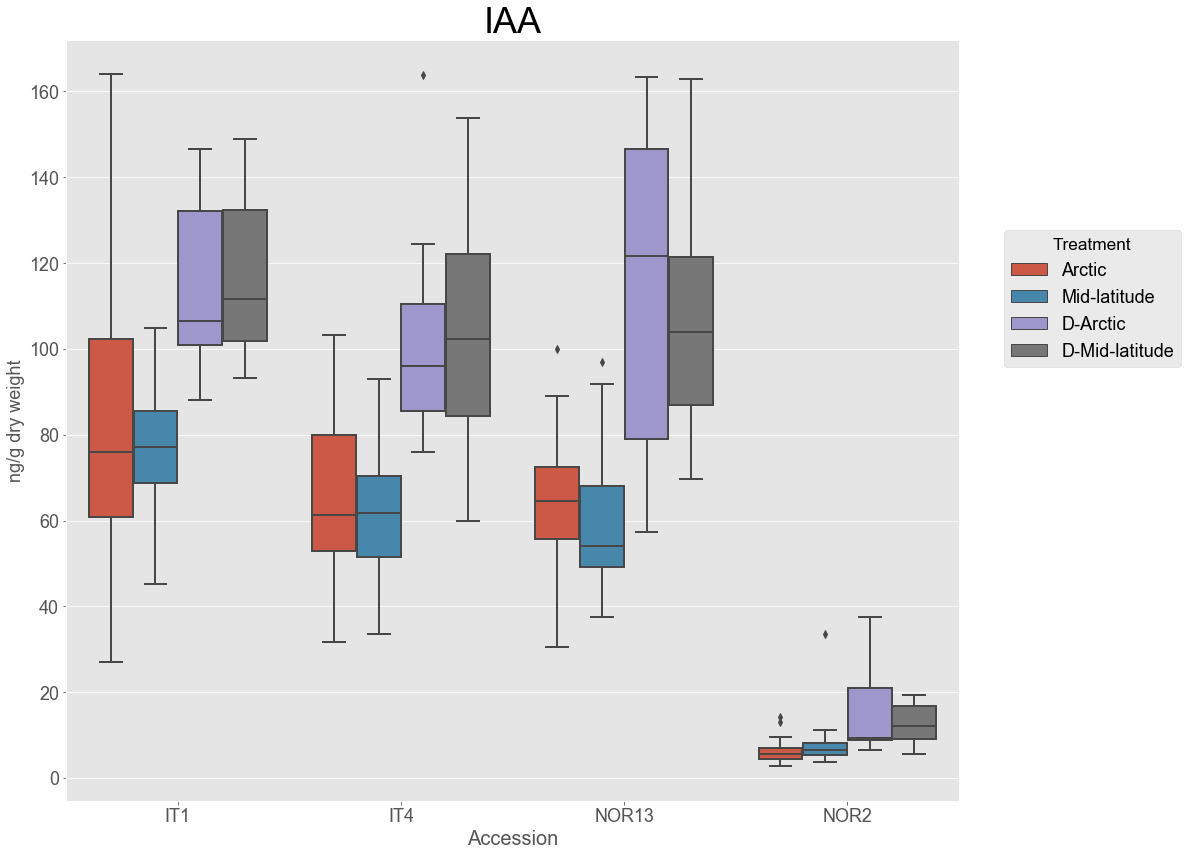

In [409]:
show_boxplot(IAA)

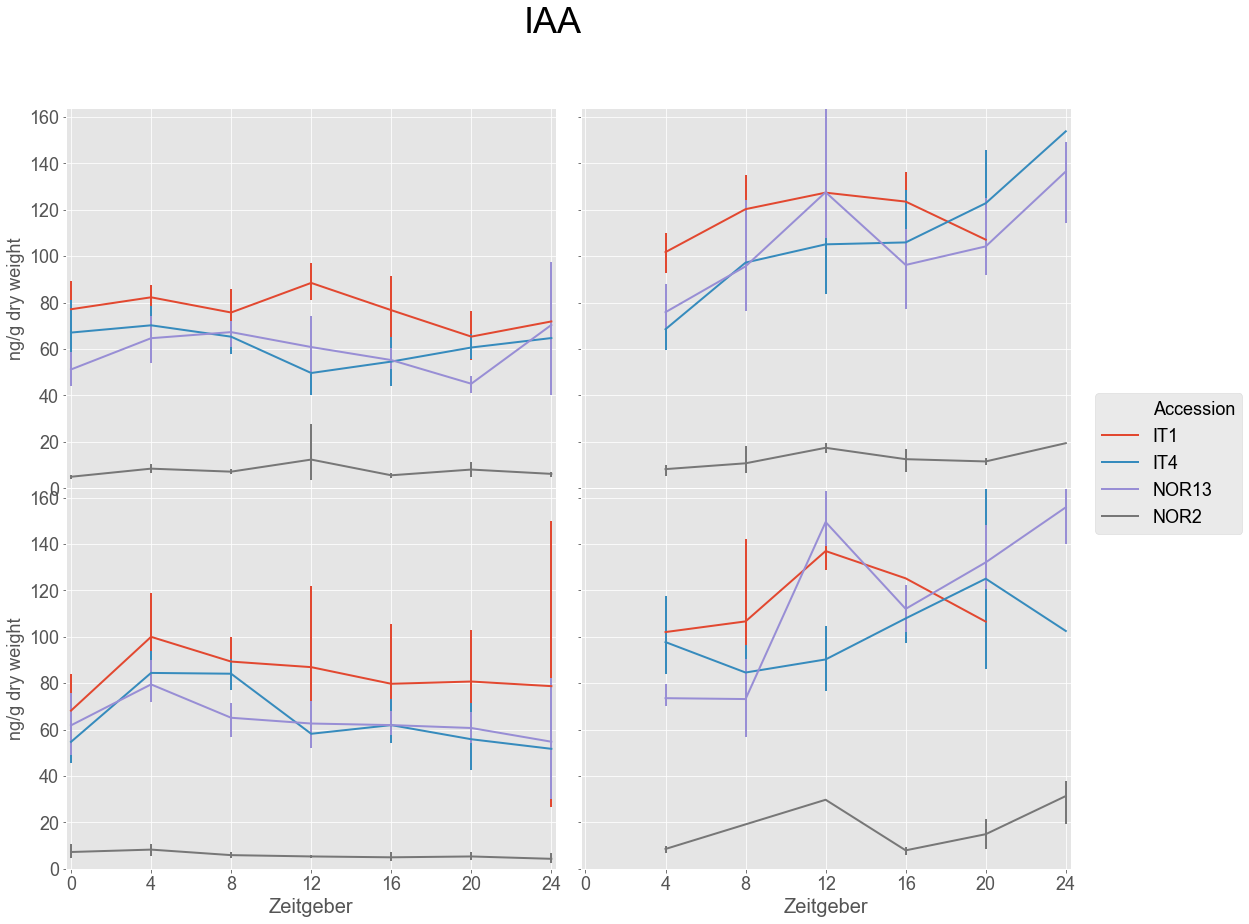

In [410]:
plot_hormone_zeitgeber(IAA)

In [411]:
anova_table(IAA)

,sum_sq,df,F,PR(>F)
C(Accession),395672.663046,3.0,374.536504,2.136010e-116
C(Treatment),98223.226800,3.0,92.976310,8.573792e-46
C(Accession):C(Treatment),21476.146541,9.0,6.776309,4.439899e-09
Residual,142618.433405,405.0,NaN,NaN


In [412]:
tukey_results(IAA)

,Treatment,Accession_1,Accession_2,meandiff,lower,upper,p-adj
3,Arctic,IT1,IT4,-18.3306,-32.9826,-3.6786,0.0021
7,Arctic,IT1,NOR13,-19.2537,-33.9057,-4.6017,0.0008
11,Arctic,IT1,NOR2,-77.6325,-92.5866,-62.6784,0.0000
61,Arctic,IT4,NOR2,-59.3019,-74.2560,-44.3478,0.0000
95,Arctic,NOR13,NOR2,-58.3788,-73.3329,-43.4247,0.0000
26,D-Arctic,IT1,NOR2,-98.5420,-125.0484,-72.0356,0.0000
72,D-Arctic,IT4,NOR2,-83.9535,-108.4710,-59.4361,0.0000
102,D-Arctic,NOR13,NOR2,-99.4602,-123.2986,-75.6218,0.0000
40,D-Mid-latitude,IT1,NOR2,-102.9225,-126.6007,-79.2442,0.0000
82,D-Mid-latitude,IT4,NOR2,-90.7429,-113.6183,-67.8675,0.0000


In [413]:
# zt_IAA_Ar = plot_hormone_zeitgeber_Ar(IAA)
# zt_IAA_Ar.savefig("Hormone_results_figures/zt_IAA_Ar.png", dpi=300, bbox_inches='tight')

In [414]:
# zt_IAA_Mid = plot_hormone_zeitgeber_Mid(IAA)
# zt_IAA_Mid.savefig("Hormone_results_figures/zt_IAA_Mid.png", dpi=300, bbox_inches='tight')

In [415]:
# display_significant_t_tests(IAA)

# Abscissic acid (ABA)

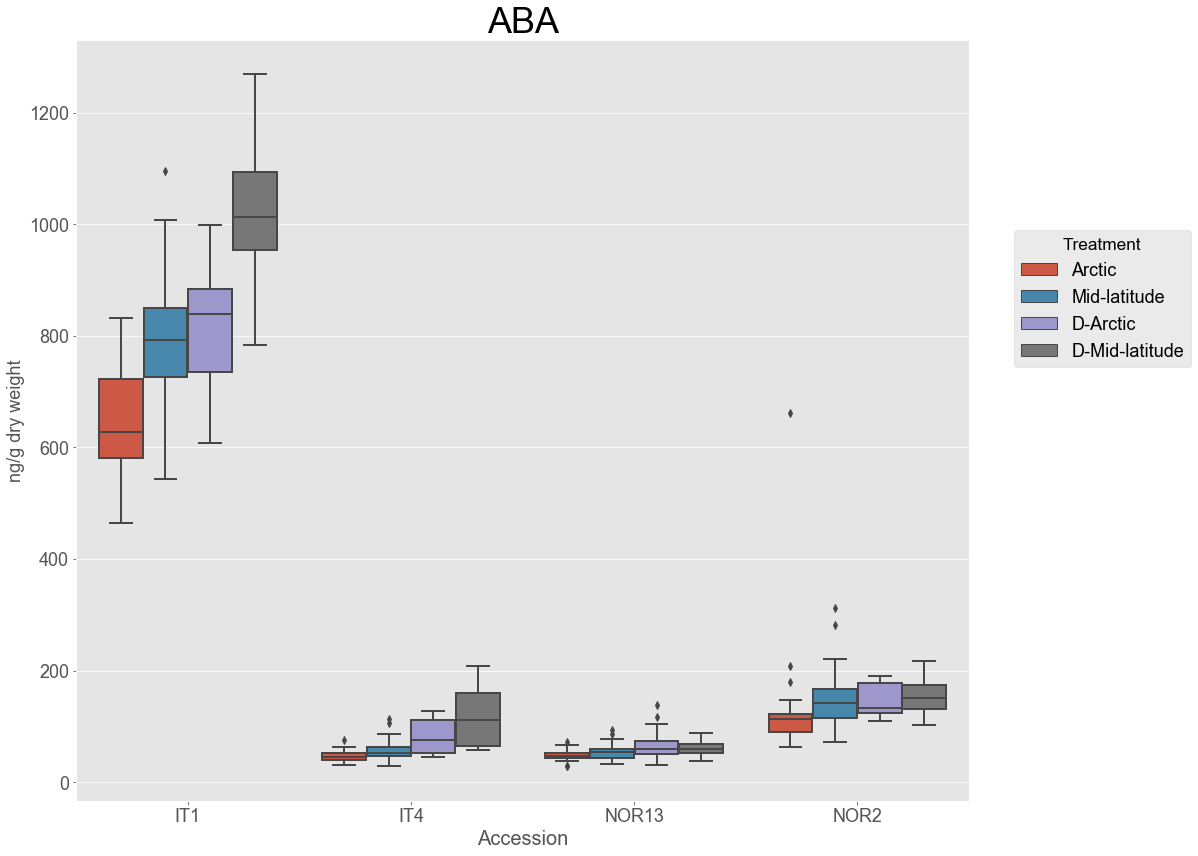

In [416]:
show_boxplot(ABA)

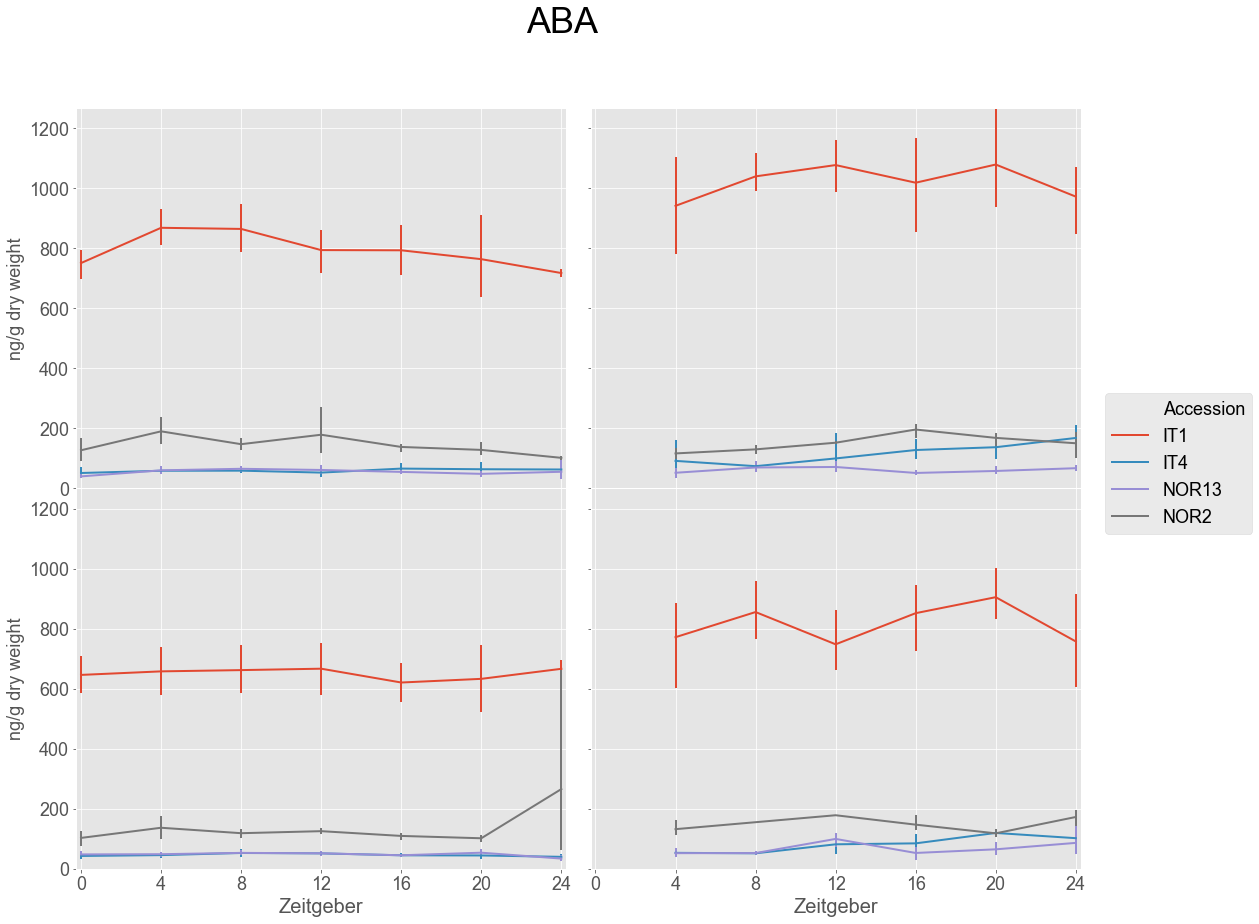

In [417]:
plot_hormone_zeitgeber(ABA)

In [418]:
anova_table(ABA)

,sum_sq,df,F,PR(>F)
C(Accession),4.184187e+07,3.0,3122.348090,1.421129e-288
C(Treatment),7.355437e+05,3.0,54.888166,5.394317e-30
C(Accession):C(Treatment),1.093911e+06,9.0,27.210142,4.016455e-37
Residual,1.893975e+06,424.0,NaN,NaN


In [419]:
tukey_results(ABA)

,Treatment,Accession_1,Accession_2,meandiff,lower,upper,p-adj
3,Arctic,IT1,IT4,-602.9749,-655.1444,-550.8055,0.0000
7,Arctic,IT1,NOR13,-600.6299,-652.7994,-548.4605,0.0000
11,Arctic,IT1,NOR2,-521.8598,-575.1050,-468.6146,0.0000
61,Arctic,IT4,NOR2,81.1151,27.8699,134.3603,0.0000
95,Arctic,NOR13,NOR2,78.7701,25.5249,132.0153,0.0001
18,D-Arctic,IT1,IT4,-733.1126,-809.9040,-656.3213,0.0000
22,D-Arctic,IT1,NOR13,-747.2242,-824.0156,-670.4329,0.0000
26,D-Arctic,IT1,NOR2,-669.9317,-753.7824,-586.0810,0.0000
32,D-Mid-latitude,IT1,IT4,-905.3070,-982.0984,-828.5157,0.0000
36,D-Mid-latitude,IT1,NOR13,-960.1275,-1036.9188,-883.3361,0.0000


In [420]:
# zt_ABA_Ar = plot_hormone_zeitgeber_Ar(ABA)
# zt_ABA_Ar.savefig("Hormone_results_figures/zt_ABA_Ar.png", dpi=300, bbox_inches='tight')

In [421]:
# zt_ABA_Mid = plot_hormone_zeitgeber_Mid(ABA)
# zt_ABA_Mid.savefig("Hormone_results_figures/zt_ABA_Mid.png", dpi=300, bbox_inches='tight')

In [423]:
# display_significant_t_tests(ABA)

# Salicylic acid (SA)

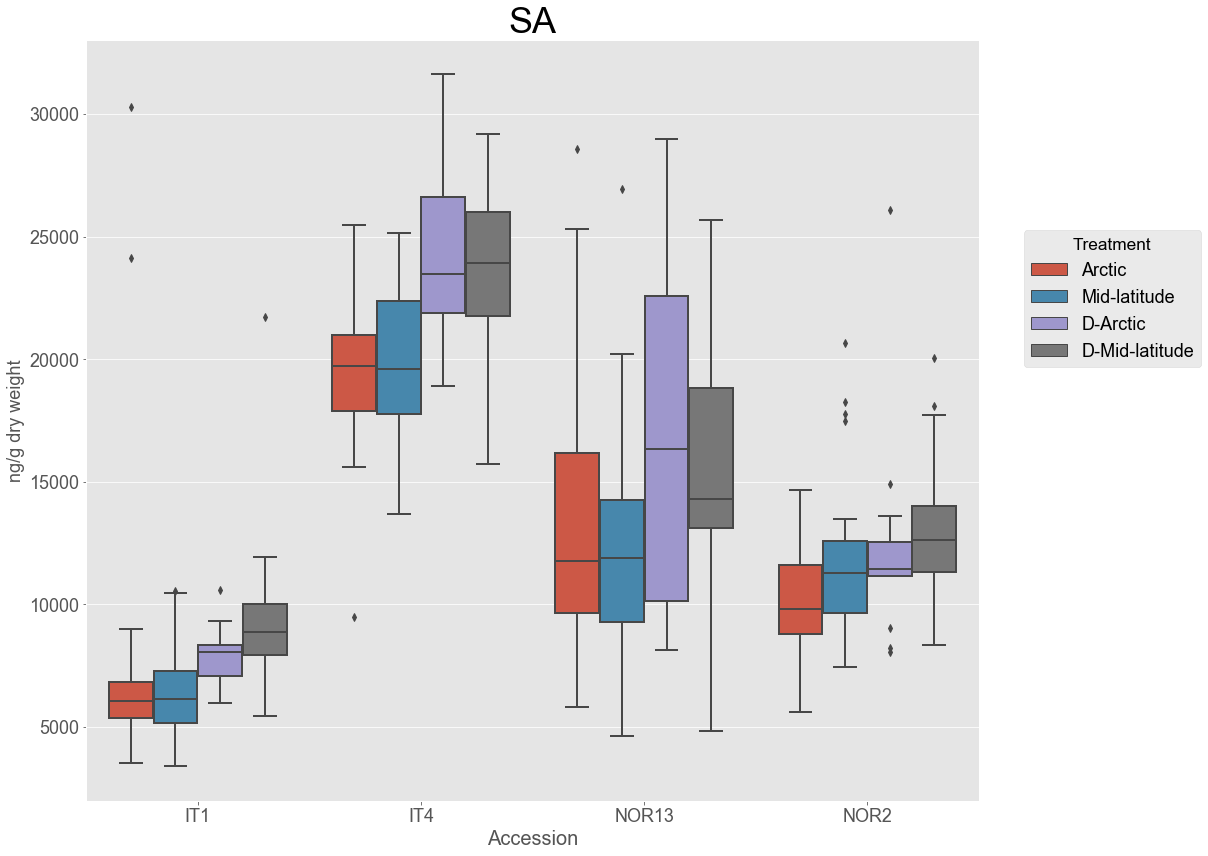

In [424]:
show_boxplot(SA)

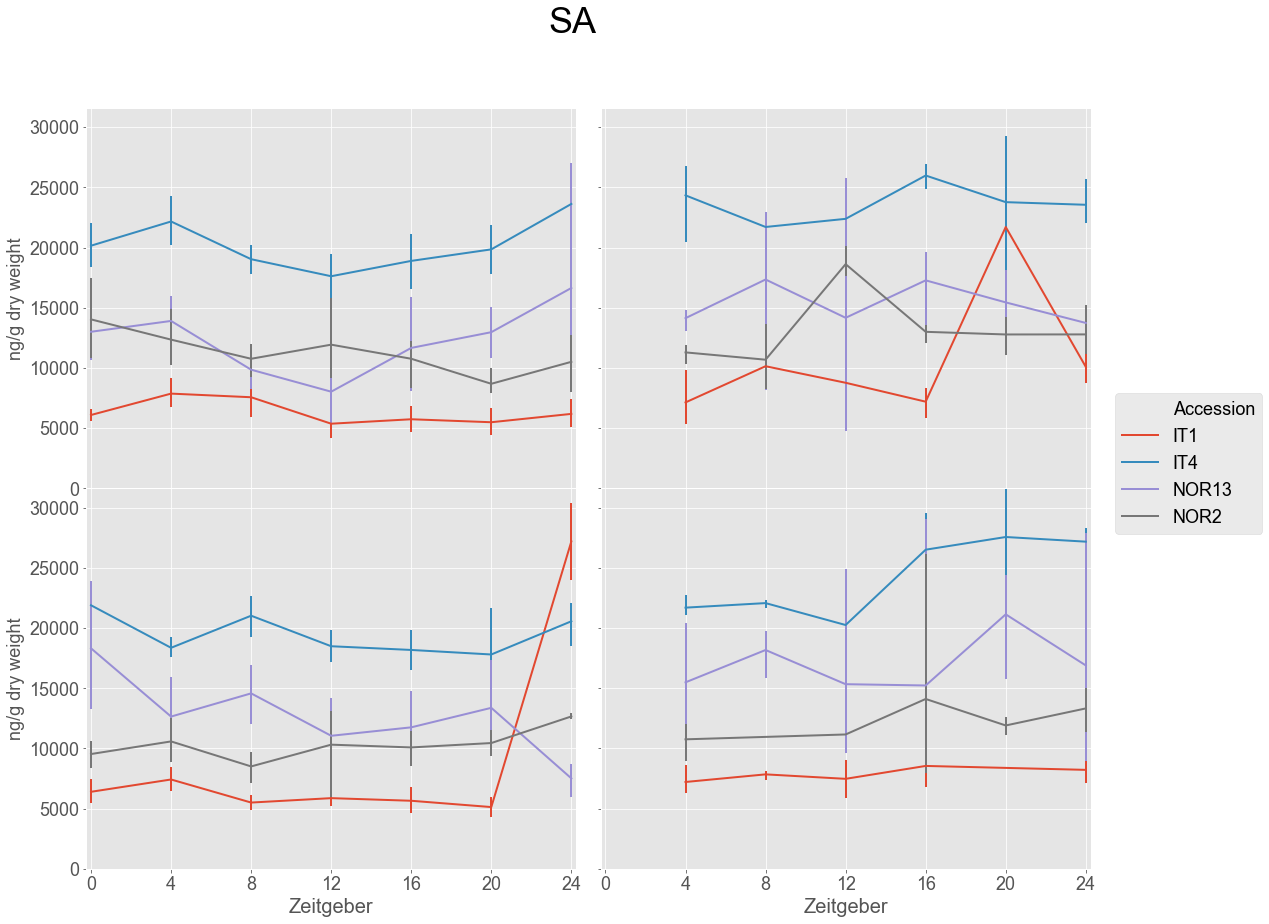

In [425]:
plot_hormone_zeitgeber(SA)

In [426]:
anova_table(SA)

,sum_sq,df,F,PR(>F)
C(Accession),1.088179e+10,3.0,246.465569,5.712769e-92
C(Treatment),8.630888e+08,3.0,19.548402,7.084194e-12
C(Accession):C(Treatment),2.295486e+08,9.0,1.733042,7.952275e-02
Residual,6.137041e+09,417.0,NaN,NaN


In [427]:
tukey_results(SA)

,Treatment,Accession_1,Accession_2,meandiff,lower,upper,p-adj
3,Arctic,IT1,IT4,12280.7734,9266.3356,15295.2112,-0.0000
7,Arctic,IT1,NOR13,6038.8517,3024.4139,9053.2895,0.0000
57,Arctic,IT4,NOR13,-6241.9217,-9236.7213,-3247.1221,0.0000
61,Arctic,IT4,NOR2,-9358.2035,-12437.3801,-6279.0268,-0.0000
95,Arctic,NOR13,NOR2,-3116.2818,-6195.4584,-37.1051,0.0439
18,D-Arctic,IT1,IT4,16355.0258,11731.6397,20978.4118,-0.0000
22,D-Arctic,IT1,NOR13,9186.5836,4563.1975,13809.9696,0.0000
68,D-Arctic,IT4,NOR13,-7168.4422,-11576.6679,-2760.2166,0.0000
72,D-Arctic,IT4,NOR2,-11794.6895,-16608.1564,-6981.2226,0.0000
32,D-Mid-latitude,IT1,IT4,14144.8207,9600.9257,18688.7157,-0.0000


In [428]:
# zt_SA_Ar = plot_hormone_zeitgeber_Ar(SA)
# zt_SA_Ar.savefig("Hormone_results_figures/zt_SA_Ar.png", dpi=300, bbox_inches='tight')

In [429]:
# zt_SA_Mid = plot_hormone_zeitgeber_Mid(SA)
# zt_SA_Mid.savefig("Hormone_results_figures/zt_SA_Mid.png", dpi=300, bbox_inches='tight')

In [430]:
# display_significant_t_tests(SA)

## Jasmonic acid (JA)

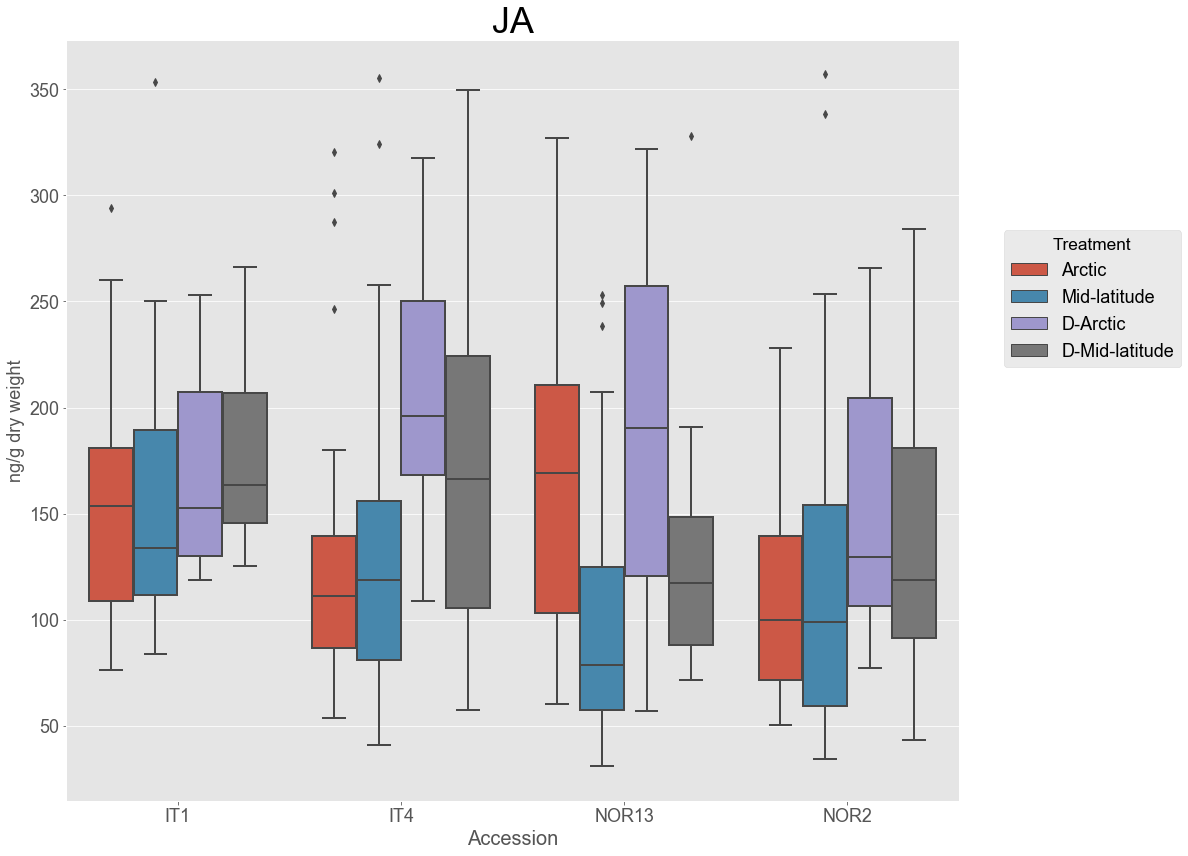

In [431]:
show_boxplot(JA)

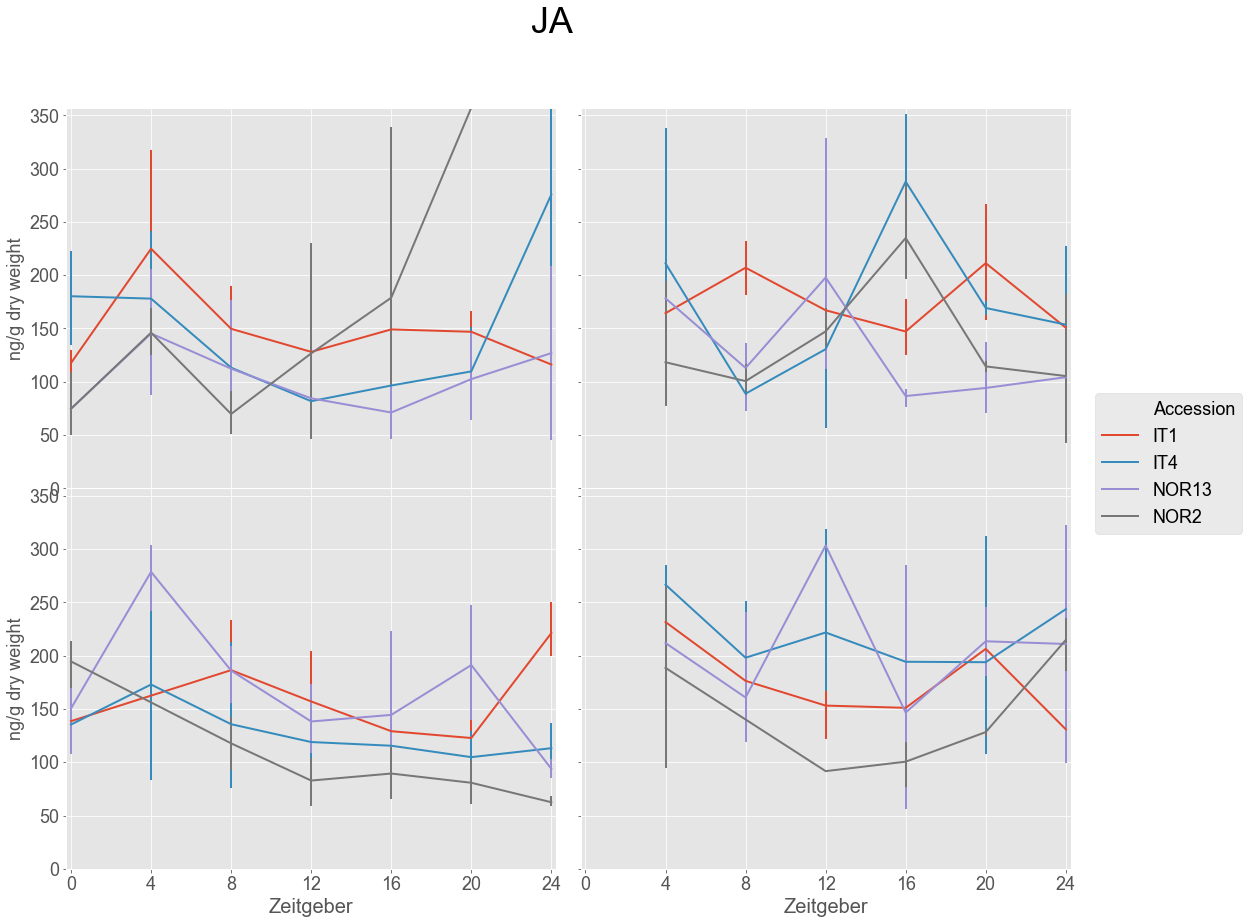

In [432]:
plot_hormone_zeitgeber(JA)

In [433]:
anova_table(JA)

,sum_sq,df,F,PR(>F)
C(Accession),5.464220e+04,3.0,4.268845,5.552917e-03
C(Treatment),1.526141e+05,3.0,11.922762,1.766626e-07
C(Accession):C(Treatment),1.210604e+05,9.0,3.152557,1.104828e-03
Residual,1.629896e+06,382.0,NaN,NaN


In [434]:
tukey_results(JA)

,Treatment,Accession_1,Accession_2,meandiff,lower,upper,p-adj


In [435]:
# zt_JA_Ar = plot_hormone_zeitgeber_Ar(JA)
# zt_JA_Ar.savefig("Hormone_results_figures/zt_JA_Ar.png", dpi=300, bbox_inches='tight')

In [436]:
# zt_JA_Mid = plot_hormone_zeitgeber_Mid(JA)
# zt_JA_Mid.savefig("Hormone_results_figures/zt_JA_Mid.png", dpi=300, bbox_inches='tight')

In [437]:
# display_significant_t_tests(JA)

# Jasmonic acid Isoleucine conjugate (JA-Ile)

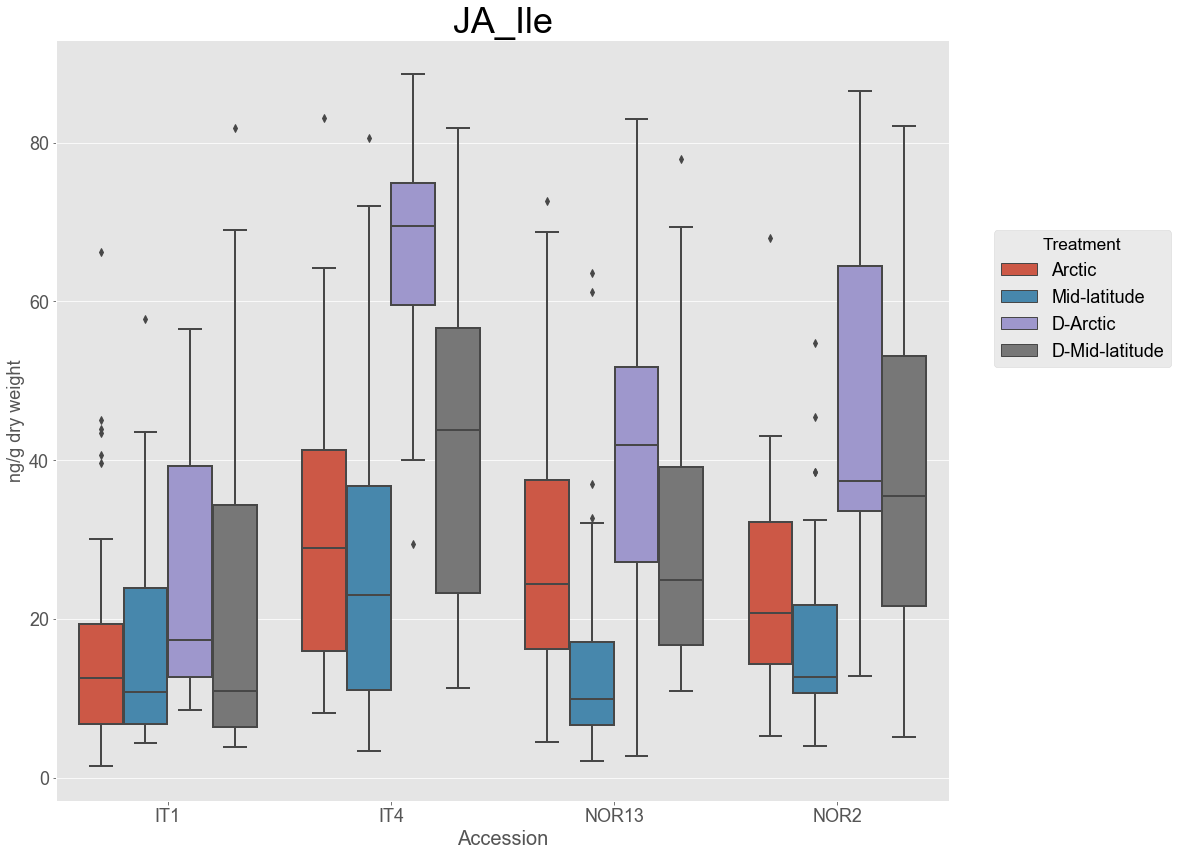

In [438]:
show_boxplot(JA_Ile)

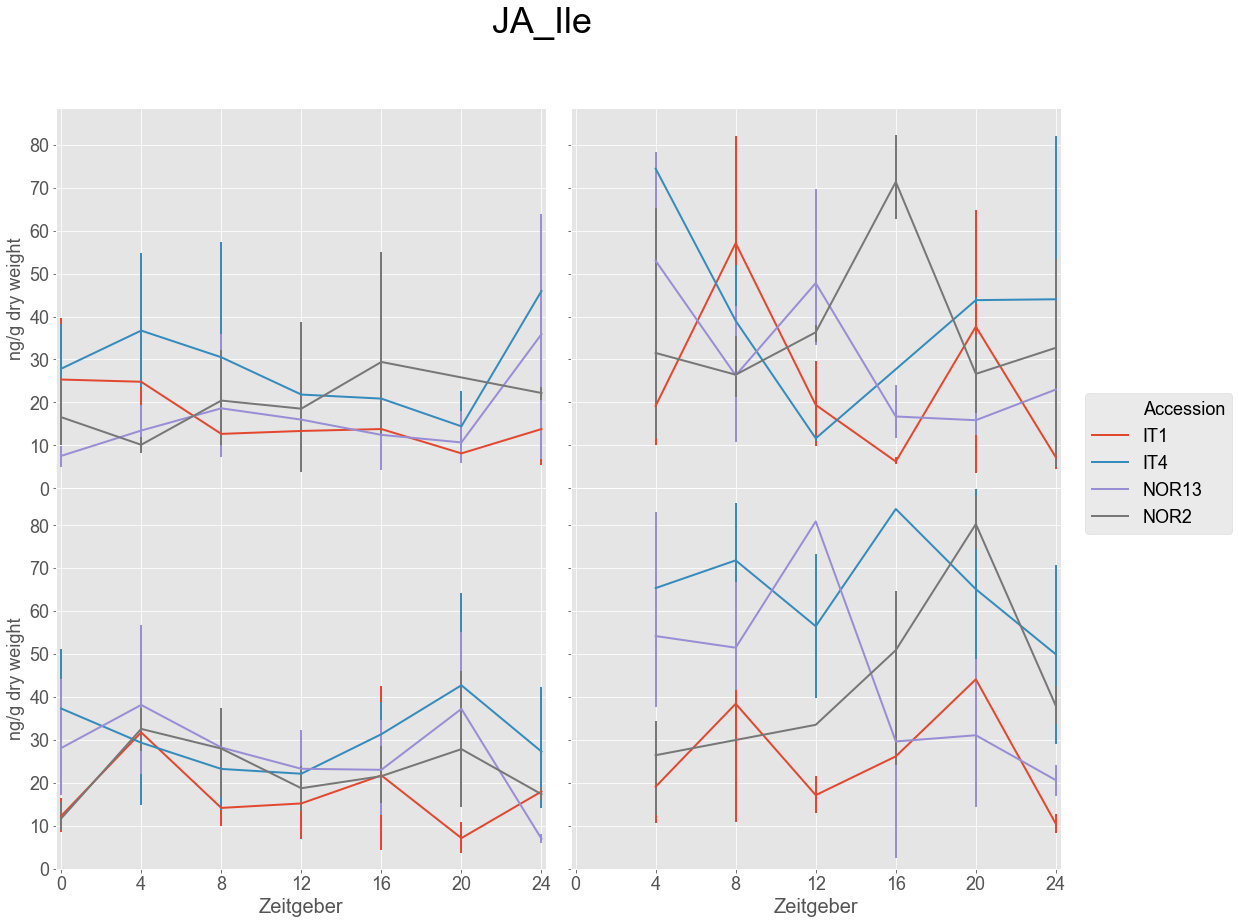

In [439]:
plot_hormone_zeitgeber(JA_Ile)

In [440]:
anova_table(JA_Ile)

,sum_sq,df,F,PR(>F)
C(Accession),14422.106847,3.0,15.795298,1.034745e-09
C(Treatment),28658.943153,3.0,31.387685,3.436619e-18
C(Accession):C(Treatment),6912.177192,9.0,2.523439,8.061830e-03
Residual,118393.873317,389.0,NaN,NaN


In [441]:
tukey_results(JA_Ile)

,Treatment,Accession_1,Accession_2,meandiff,lower,upper,p-adj
18,D-Arctic,IT1,IT4,38.5906,16.6913,60.4898,0.0000
68,D-Arctic,IT4,NOR13,-23.0646,-45.8637,-0.2655,0.0441


In [442]:
# zt_JA_Ile_Ar = plot_hormone_zeitgeber_Ar(JA_Ile)
# zt_JA_Ile_Ar.savefig("Hormone_results_figures/zt_JA_Ile_Ar.png", dpi=300, bbox_inches='tight')

In [443]:
# zt_JA_Ile_Mid = plot_hormone_zeitgeber_Mid(JA_Ile)
# zt_JA_Ile_Mid.savefig("Hormone_results_figures/zt_JA_Ile_Mid.png", dpi=300, bbox_inches='tight')

In [444]:
# display_significant_t_tests(JA_Ile)

# Jasmonate catabolites (OH-JA)

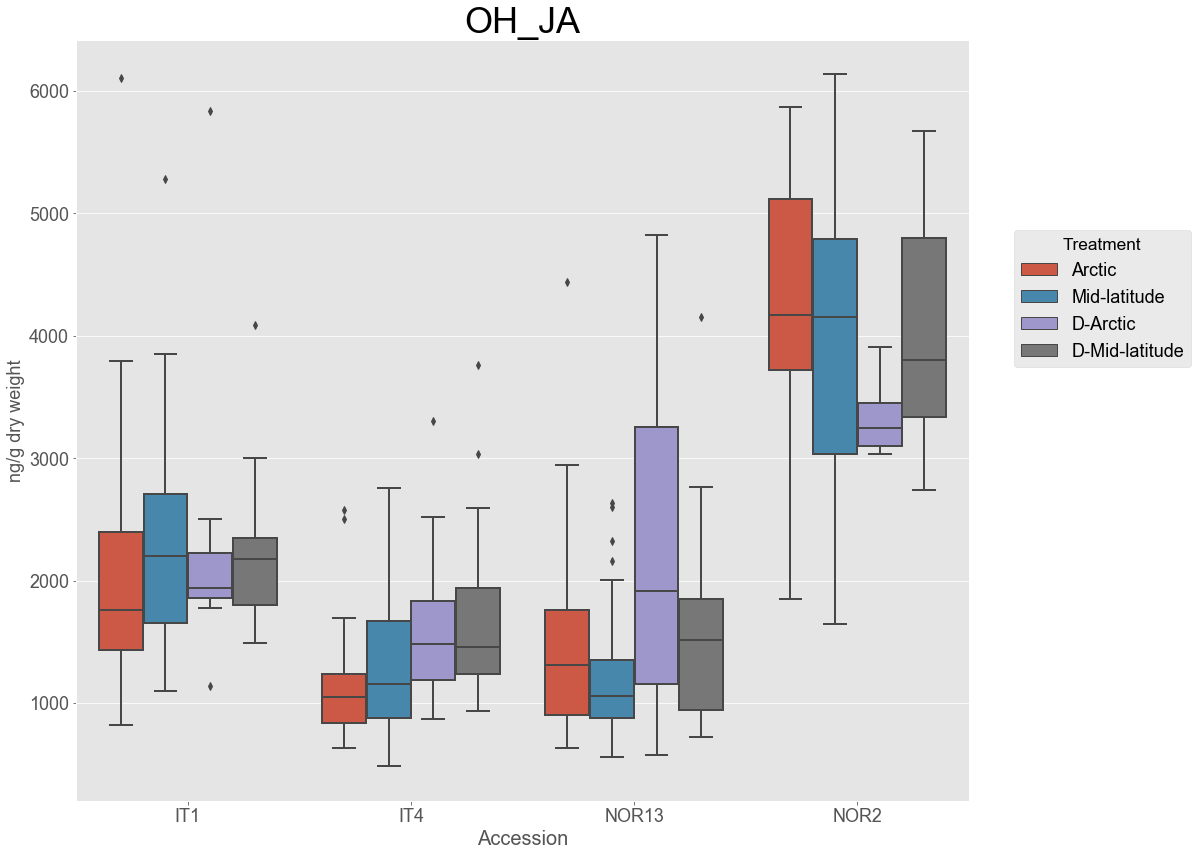

In [445]:
show_boxplot(OH_JA)

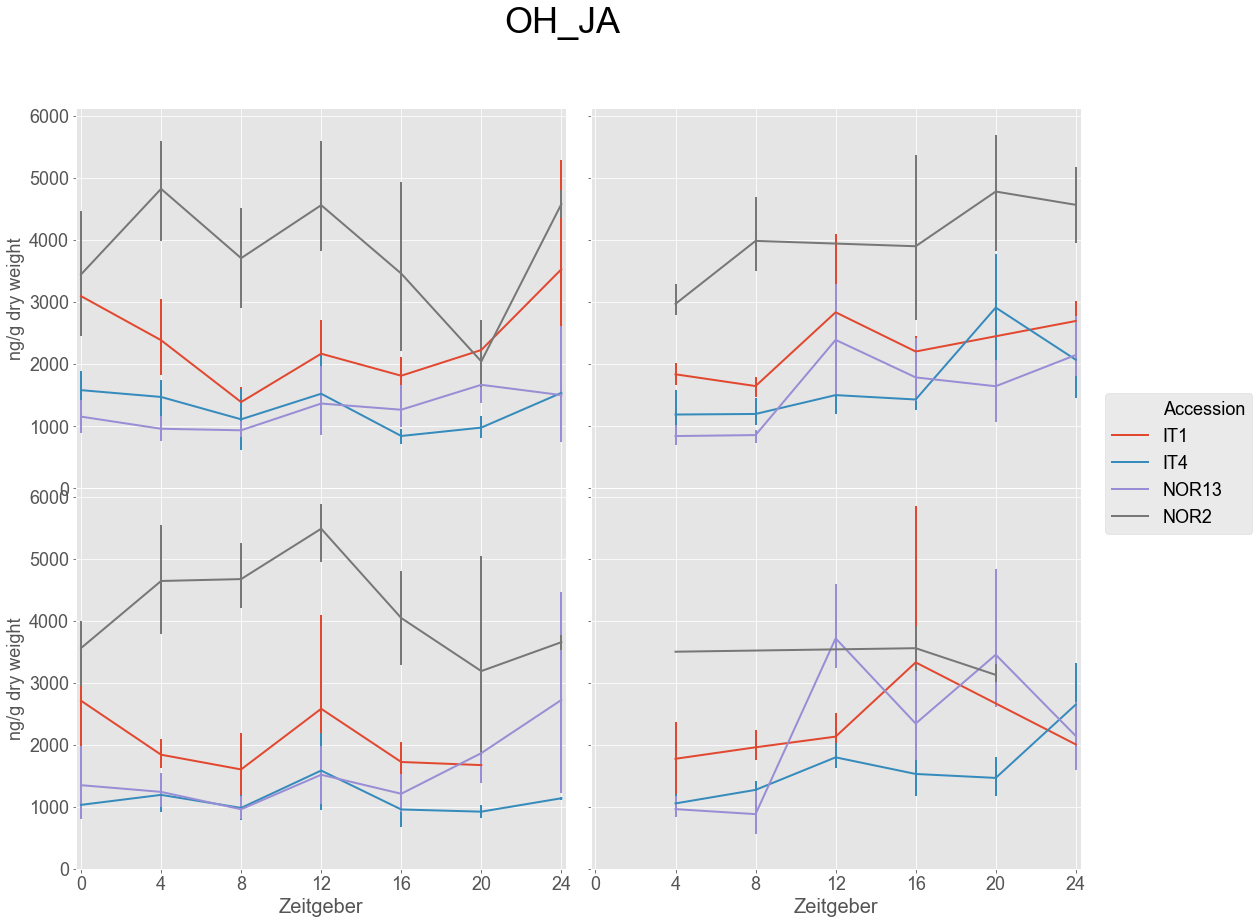

In [446]:
plot_hormone_zeitgeber(OH_JA)

In [447]:
anova_table(OH_JA)

,sum_sq,df,F,PR(>F)
C(Accession),3.739449e+08,3.0,174.951305,6.491122e-72
C(Treatment),6.985147e+06,3.0,3.268023,2.133984e-02
C(Accession):C(Treatment),1.794913e+07,9.0,2.799186,3.407367e-03
Residual,2.785774e+08,391.0,NaN,NaN


In [448]:
tukey_results(OH_JA)

,Treatment,Accession_1,Accession_2,meandiff,lower,upper,p-adj
3,Arctic,IT1,IT4,-908.1129,-1580.9086,-235.3171,0.0005
11,Arctic,IT1,NOR2,2232.8259,1491.7319,2973.9198,-0.0000
61,Arctic,IT4,NOR2,3140.9387,2412.1630,3869.7145,-0.0000
95,Arctic,NOR13,NOR2,2792.3791,2063.6033,3521.1549,-0.0000
72,D-Arctic,IT4,NOR2,1705.0235,332.7841,3077.2629,0.0024
40,D-Mid-latitude,IT1,NOR2,1761.3330,679.5865,2843.0795,0.0000
82,D-Mid-latitude,IT4,NOR2,2288.8209,1251.5054,3326.1364,0.0000
108,D-Mid-latitude,NOR13,NOR2,2394.2663,1356.9508,3431.5818,0.0000
45,Mid-latitude,IT1,IT4,-1011.5849,-1670.7874,-352.3824,0.0000
49,Mid-latitude,IT1,NOR13,-1039.1579,-1698.3604,-379.9554,0.0000


In [449]:
# zt_OH_JA_Ar = plot_hormone_zeitgeber_Ar(OH_JA)
# zt_OH_JA_Ar.savefig("Hormone_results_figures/zt_OH_JA_Ar.png", dpi=300, bbox_inches='tight')

In [450]:
# zt_OH_JA_Mid = plot_hormone_zeitgeber_Mid(OH_JA)
# zt_OH_JA_Mid.savefig("Hormone_results_figures/zt_OH_JA_Mid.png", dpi=300, bbox_inches='tight')

In [451]:
# display_significant_t_tests(OH_JA)